# Building a Discriminator: Real vs. Fake Classification

## Overview

In this demo, we'll build and test a **discriminator** - the "judge" in a GAN that learns to distinguish real images from generated ones.

### Key Concept
The discriminator is a binary classifier with a twist:
- **Traditional classifier**: Trained once, then used for predictions
- **GAN discriminator**: Trained continuously in a competition with the generator

### What You'll Learn
- Discriminator architecture (LeakyReLU, Sigmoid)
- How to evaluate raw predictions (before adversarial training)
- Binary Cross-Entropy loss for classification
- Setting up a mixed batch (real + fake images)

### The Big Picture
After this lesson, you'll understand:
1. **Generator** (Lesson 3): Maps noise → images
2. **Discriminator** (This lesson): Maps images → real/fake probability
3. **Adversarial Training** (Next): They compete, both improve

## Part 1: Imports and Setup

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import BCELoss

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# alternatively check if device is mps and move to mps
if torch.backends.mps.is_available():
    device = torch.device("mps")


print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
if device == "cuda":
    torch.cuda.manual_seed(42)


Using device: cuda


## Part 2: Create the Discriminator

Now let's create our discriminator and understand its structure.

In [4]:
# Import the SimpleDiscriminator and generator functions
from models.basic_gan import create_discriminator, create_generator

# Create the discriminator
discriminator = create_discriminator(device=device)
print("Discriminator architecture:")
print(discriminator)
print(f"\nTotal parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


Discriminator architecture:
SimpleDiscriminator(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Total parameters: 533,505


## Part 3: Load the Generator

To test our discriminator, we need a generator to create fake images. We'll use the one we built in Module 3.

In [5]:
# Create the generator in eval mode 
generator = create_generator(latent_dim=100, device=device)
generator.eval()  # Put in evaluation mode

print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")


Generator parameters: 293,136


## Part 4: Generate Fake Images

Let's generate some fake images using the generator. We'll create 8 random noise vectors and generate images from them.

In [6]:
# Generate fake images
batch_size = 16  # Total batch size (will be split: 8 real + 8 fake)
latent_dim = 100

# Calculate how many fake images we need (half of total batch)
num_fake = batch_size // 2

# Sample noise from standard normal distribution
noise = torch.randn(num_fake, latent_dim, device=device)
print(f"Noise shape: {noise.shape}")
print(f"Noise statistics: mean={noise.mean():.3f}, std={noise.std():.3f}")

# Generate images (no gradient needed for generation)
with torch.no_grad():
    fake_images = generator(noise)

print(f"\nGenerated images shape: {fake_images.shape}")
print(f"Image value range: [{fake_images.min():.3f}, {fake_images.max():.3f}]")

# Reshape from (batch, 784) to (batch, 1, 28, 28) for visualization
fake_images_2d = fake_images.view(-1, 1, 28, 28)
print(f"Reshaped for visualization: {fake_images_2d.shape}")


Noise shape: torch.Size([8, 100])
Noise statistics: mean=0.033, std=1.009

Generated images shape: torch.Size([8, 784])
Image value range: [-0.365, 0.381]
Reshaped for visualization: torch.Size([8, 1, 28, 28])


## Part 5: Create Mixed Batch (Real + Fake)

Now let's create a batch containing both real MNIST images and our fake generated images. This is the training data for the discriminator.

In [7]:
# Create synthetic "real" images (in practice these would be from MNIST)
# We'll use random images normalized to [0, 1] as a stand-in
half_batch = batch_size // 2
real_images = torch.rand(half_batch, 1, 28, 28, device=device)
print(f"Real images shape: {real_images.shape}")
print(f"Real images value range: [{real_images.min():.3f}, {real_images.max():.3f}]")

# Prepare labels: 1 for real, 0 for fake
real_targets = torch.ones(half_batch, 1, device=device)
fake_targets = torch.zeros(half_batch, 1, device=device)

# Mix real and fake images
mixed_images = torch.cat([real_images, fake_images_2d], dim=0)
mixed_targets = torch.cat([real_targets, fake_targets], dim=0)

print(f"\nMixed batch:")
print(f"  Total images: {mixed_images.shape}")
print(f"  First {half_batch} are 'real' (target=1)")
print(f"  Last {half_batch} are 'fake' (target=0)")
print(f"  Targets shape: {mixed_targets.shape}")


Real images shape: torch.Size([8, 1, 28, 28])
Real images value range: [0.000, 1.000]

Mixed batch:
  Total images: torch.Size([16, 1, 28, 28])
  First 8 are 'real' (target=1)
  Last 8 are 'fake' (target=0)
  Targets shape: torch.Size([16, 1])


## Part 6: Discriminator Predictions

Pass the mixed batch through the discriminator. It will output a probability between 0 and 1 for each image.

In [8]:
# Put discriminator in eval mode
discriminator.eval()

# Get predictions (no gradient needed)
with torch.no_grad():
    predictions = discriminator(mixed_images)

print(f"Predictions shape: {predictions.shape}")
print(f"Predictions (probabilities for each image):")
print(predictions.squeeze().detach().cpu().numpy())

# Separate predictions
real_preds = predictions[:half_batch]
fake_preds = predictions[half_batch:]

print(
    f"\n'Real' image predictions (should be ~1.0): {real_preds.squeeze().detach().cpu().numpy()}"
)
print(
    f"'Fake' image predictions (should be ~0.0): {fake_preds.squeeze().detach().cpu().numpy()}"
)

# Count correct classifications (threshold at 0.5)
real_correct = (real_preds > 0.5).sum().item()
fake_correct = (fake_preds < 0.5).sum().item()
accuracy = (real_correct + fake_correct) / batch_size * 100

print(f"\nClassification accuracy (untrained): {accuracy:.1f}%")
print(f"  Real images classified as real: {real_correct}/{half_batch}")
print(f"  Fake images classified as fake: {fake_correct}/{half_batch}")


Predictions shape: torch.Size([16, 1])
Predictions (probabilities for each image):
[0.48521918 0.4723473  0.48008287 0.48048562 0.47841468 0.47722876
 0.48390916 0.48074022 0.4888456  0.487401   0.48978928 0.48604152
 0.48855156 0.48583513 0.48721483 0.48633277]

'Real' image predictions (should be ~1.0): [0.48521918 0.4723473  0.48008287 0.48048562 0.47841468 0.47722876
 0.48390916 0.48074022]
'Fake' image predictions (should be ~0.0): [0.4888456  0.487401   0.48978928 0.48604152 0.48855156 0.48583513
 0.48721483 0.48633277]

Classification accuracy (untrained): 50.0%
  Real images classified as real: 0/8
  Fake images classified as fake: 8/8


## Part 7: Compute Binary Cross-Entropy Loss

The loss measures how well the discriminator's predictions match the true labels. High loss means the discriminator is confused.

In [9]:
# Define Binary Cross-Entropy loss
criterion = BCELoss()

# Compute loss
loss = criterion(predictions, mixed_targets)

print(f"Binary Cross-Entropy Loss: {loss.item():.4f}")
print(f"\nInterpretation:")
print(f"  - Loss ≈ 0.693: Random guessing (untrained discriminator)")
print(f"  - Loss < 0.693: Discriminator has learned something")
print(f"  - Loss → 0: Perfect discrimination (real/fake)")
print(f"\nOur untrained discriminator loss: {loss.item():.4f}")
print(f"Expected for random predictions: ~0.6931")

# The log(2) loss for random binary classification
import math

expected_random = -math.log(0.5)  # -log(0.5) ≈ 0.693
print(f"Random guessing baseline: {expected_random:.4f}")


Binary Cross-Entropy Loss: 0.7014

Interpretation:
  - Loss ≈ 0.693: Random guessing (untrained discriminator)
  - Loss < 0.693: Discriminator has learned something
  - Loss → 0: Perfect discrimination (real/fake)

Our untrained discriminator loss: 0.7014
Expected for random predictions: ~0.6931
Random guessing baseline: 0.6931


## Part 8: Analysis and Visualization

Let's visualize the discriminator's predictions to understand its behavior.

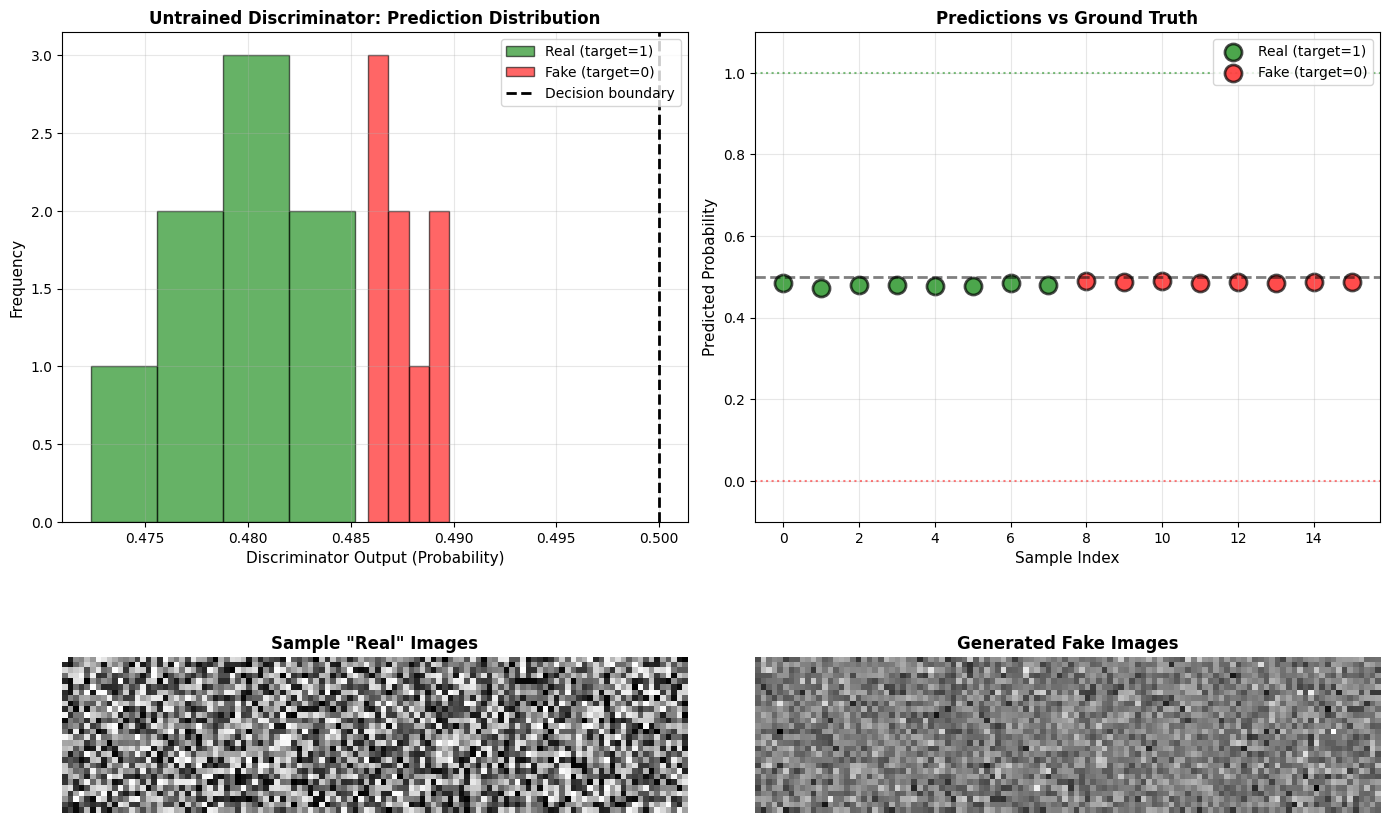


KEY INSIGHTS
1. Untrained discriminator has ~50% accuracy (random guessing)
2. Predictions are close to 0.5 (maximum confusion)
3. BCE loss is near 0.693 (log(2), the maximum for binary classification)
4. After training, the discriminator should learn to separate real from fake
5. In a GAN training loop:
   - Discriminator learns to minimize loss on real/fake classification
   - Generator learns to fool the discriminator


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predictions histogram
ax = axes[0, 0]
real_preds_np = real_preds.squeeze().cpu().numpy()
fake_preds_np = fake_preds.squeeze().cpu().numpy()

ax.hist(
    real_preds_np,
    bins=4,
    alpha=0.6,
    label="Real (target=1)",
    color="green",
    edgecolor="black",
)
ax.hist(
    fake_preds_np,
    bins=4,
    alpha=0.6,
    label="Fake (target=0)",
    color="red",
    edgecolor="black",
)
ax.axvline(0.5, color="black", linestyle="--", linewidth=2, label="Decision boundary")
ax.set_xlabel("Discriminator Output (Probability)", fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)
ax.set_title(
    "Untrained Discriminator: Prediction Distribution", fontsize=12, fontweight="bold"
)
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Individual predictions with targets
ax = axes[0, 1]
x_pos = np.arange(batch_size)
predictions_np = predictions.squeeze().cpu().numpy()
colors = ["green" if i < half_batch else "red" for i in range(batch_size)]

ax.scatter(
    x_pos[:half_batch],
    predictions_np[:half_batch],
    s=150,
    c="green",
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
    label="Real (target=1)",
)
ax.scatter(
    x_pos[half_batch:],
    predictions_np[half_batch:],
    s=150,
    c="red",
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
    label="Fake (target=0)",
)
ax.axhline(0.5, color="black", linestyle="--", linewidth=2, alpha=0.5)
ax.axhline(1.0, color="green", linestyle=":", alpha=0.5)
ax.axhline(0.0, color="red", linestyle=":", alpha=0.5)
ax.set_xlabel("Sample Index", fontsize=11)
ax.set_ylabel("Predicted Probability", fontsize=11)
ax.set_title("Predictions vs Ground Truth", fontsize=12, fontweight="bold")
ax.set_ylim([-0.1, 1.1])
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Real images
ax = axes[1, 0]
real_grid = real_images[:4].cpu()
real_grid = real_grid.view(-1, 28, 28)
grid_img = torch.cat(
    [real_grid[i].unsqueeze(0) for i in range(min(4, len(real_grid)))], dim=2
)
ax.imshow(grid_img.squeeze().cpu().numpy(), cmap="gray")
ax.set_title('Sample "Real" Images', fontsize=12, fontweight="bold")
ax.axis("off")

# Plot 4: Fake images
ax = axes[1, 1]
fake_grid = fake_images_2d[:4].cpu()
grid_img = torch.cat(
    [fake_grid[i].view(28, 28).unsqueeze(0) for i in range(min(4, len(fake_grid)))],
    dim=2,
)
ax.imshow(grid_img.squeeze().cpu().numpy(), cmap="gray")
ax.set_title("Generated Fake Images", fontsize=12, fontweight="bold")
ax.axis("off")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
print(f"1. Untrained discriminator has ~50% accuracy (random guessing)")
print(f"2. Predictions are close to 0.5 (maximum confusion)")
print(f"3. BCE loss is near 0.693 (log(2), the maximum for binary classification)")
print(f"4. After training, the discriminator should learn to separate real from fake")
print(f"5. In a GAN training loop:")
print(f"   - Discriminator learns to minimize loss on real/fake classification")
print(f"   - Generator learns to fool the discriminator")
print("=" * 60)
